In [1]:
#for more advanced hisfile operations: https://github.com/Deltares/dfm_tools/blob/main/tests/examples/postprocess_hisnc.py
#for more advanced mapfile operations: https://github.com/Deltares/dfm_tools/blob/main/tests/examples/postprocess_mapnc_ugrid.py
import xarray as xr
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np
import dfm_tools as dfmt


In [2]:
#set paths and parameters per model
#the necessary data is automatically downloaded from opendap if needed
model = 'grevelingen' #'curvedbend' 'grevelingen' 'westernscheldt'

if model=='curvedbend':
    file_nc_his = dfmt.data.fm_curvedbend_his(return_filepath=True)
    file_nc_map = dfmt.data.fm_curvedbend_map(return_filepath=True)
    rename_mapvars = {}
    sel_slice_x, sel_slice_y = slice(1500,3500), slice(1000,3500)
    layer = 5
    crs = None
    raster_res = 100
    umag_clim = None
    scale = 1.5
    line_array = np.array([[ 104.15421399, 2042.7077107 ],
                           [2913.47878063, 2102.48057382]])
elif model=='grevelingen':
    file_nc_his = dfmt.data.fm_grevelingen_his(return_filepath=True)
    file_nc_map = dfmt.data.fm_grevelingen_map(return_filepath=True)
    rename_mapvars = {}
    sel_slice_x, sel_slice_y = slice(50000,55000), slice(None,424000)
    layer = 34
    crs = 'EPSG:28992'
    raster_res = 500
    umag_clim = None
    scale = 1.5
    line_array = np.array([[ 53181.96942503, 424270.83361629],
                           [ 55160.15232593, 416913.77136685]])
elif model=='westernscheldt':
    file_nc_his = None
    file_nc_map = dfmt.data.fm_westernscheldt_map(return_filepath=True)
    rename_mapvars = {'mesh2d_FlowElem_bl':'mesh2d_flowelem_bl'}
    sel_slice_x, sel_slice_y = slice(None,None), slice(None,None)
    layer = None
    crs = 'EPSG:4326'
    raster_res = 0.01
    umag_clim = None
    scale = 50
    line_array = None #no mesh2d_sa1 available
else:
    raise Exception(f'undefined model: {model}')


In [3]:
#open hisfile with xarray and print netcdf structure
if file_nc_his is not None:
    ds_his = xr.open_mfdataset(file_nc_his, preprocess=dfmt.preprocess_hisnc)


dropping 45 duplicate "source_sink_name" labels to avoid InvalidIndexError


c:\snapvolumestemp\mountpoints\{45c63495-0000-0000-0000-100000000000}\{79de0690-9470-4166-b9ee-4548dc416bbd}\svroot\data\dfm_tools\dfm_tools\xarray_helpers.py:83: UserWarning: Your model was run with a D-FlowFM version from before 28-10-2020 (D-Flow FM Version 1.2.41.63609 from Apr 08 2019), the layers in the hisfile are incorrect. Check UNST-2920 and UNST-3024 for more information, it was fixed from OSS 67858.
  warnings.warn(UserWarning(f'Your model was run with a D-FlowFM version from before 28-10-2020 ({source_attr_version} from {source_attr_date}), the layers in the hisfile are incorrect. Check UNST-2920 and UNST-3024 for more information, it was fixed from OSS 67858.'))


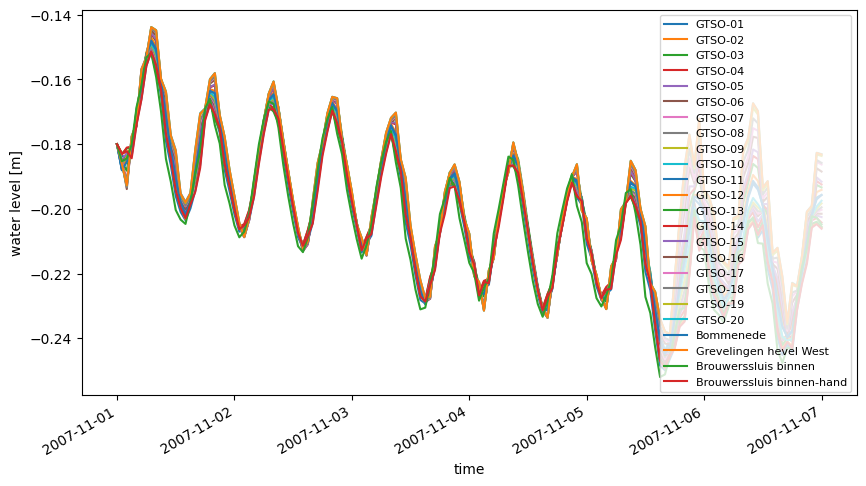

In [4]:
#plot his data: waterlevel at stations
if file_nc_his is not None:
    fig, ax = plt.subplots(1,1,figsize=(10,5))
    ds_his.waterlevel.plot.line(ax=ax, x='time')
    ax.legend(ds_his.stations.to_series(),loc=1,fontsize=8) #optional, to change legend location


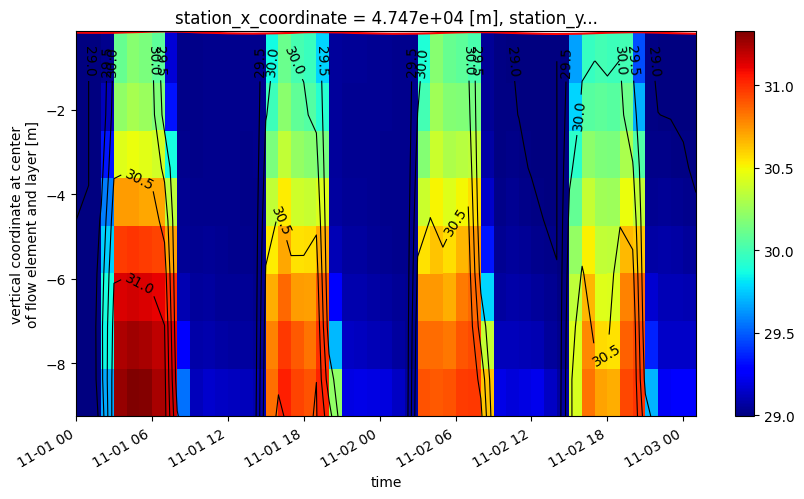

In [5]:
#plot his data: temperature zt at one station
if file_nc_his is not None:
    ds_his_sel = ds_his.isel(stations=0).isel(time=slice(0,50))
    fig, ax = plt.subplots(1,1,figsize=(10,5))
    ds_his_sel.waterlevel.plot.line(ax=ax,color='r') #waterlevel line
    pc = dfmt.plot_ztdata(ds_his_sel, varname='salinity', ax=ax, cmap='jet') #salinity pcolormesh
    fig.colorbar(pc,ax=ax)
    CS = dfmt.plot_ztdata(ds_his_sel, varname='salinity', ax=ax, only_contour=True, levels=6, colors='k', linewidths=0.8) #salinity contour
    ax.clabel(CS, fontsize=10)


In [6]:
#open+merge mapfile with xugrid(xarray) and print netcdf structure
uds_map = dfmt.open_partitioned_dataset(file_nc_map)
uds_map = uds_map.rename(rename_mapvars)


>> xu.open_dataset() with 8 partition(s): 1 2 3 4 5 6 7 8 : 1.61 sec
>> xu.merge_partitions() with 8 partition(s): 0.44 sec
>> some variables dropped with merging of partitions: ['mesh2d_face_x_bnd', 'mesh2d_face_y_bnd']
>> dfmt.open_partitioned_dataset() total: 2.04 sec


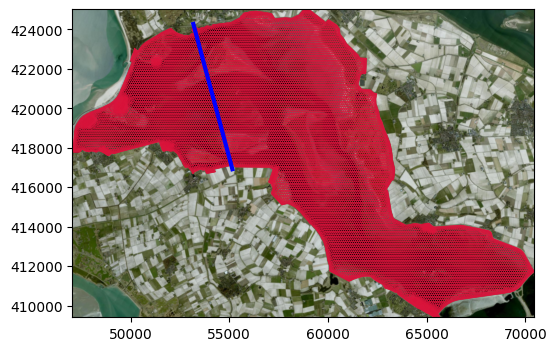

In [7]:
#plot net/grid. use random variable and plot line to get grid
fig, ax = plt.subplots(figsize=(10,4))
pc = uds_map.grid.plot(edgecolor='crimson', linewidth=0.5)
if crs is None:
    ax.set_aspect('equal')
else:
    ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)
if line_array is not None:
    ax.plot(line_array[:,0],line_array[:,1],'b',linewidth=3)


>> rasterizing ugrid Dataset with 1 face variables to shape=(31,47): 0.43 sec


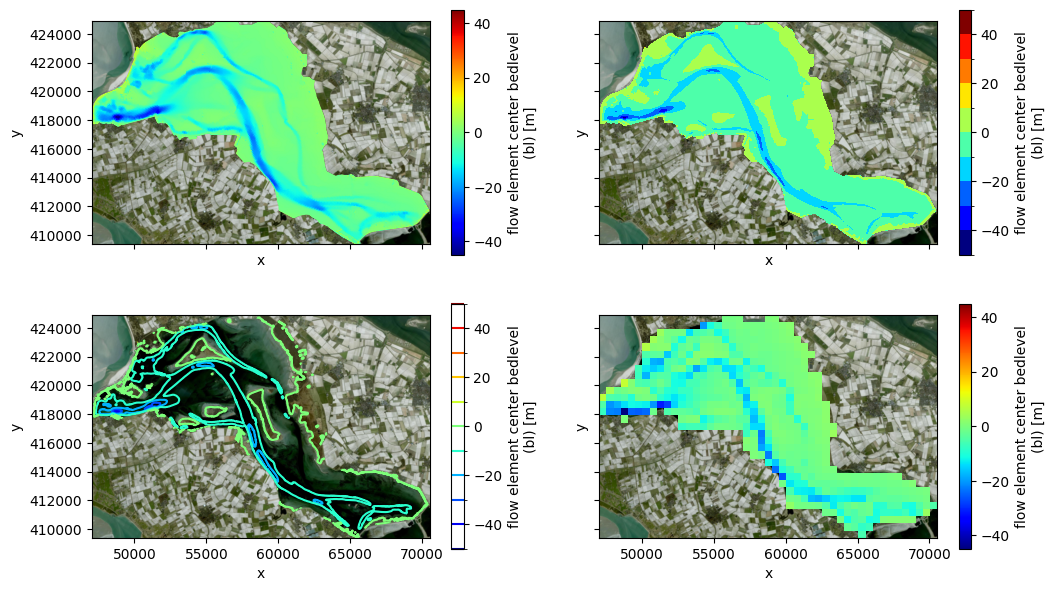

In [8]:
#plot bedlevel on map, including contour/contourf/rasterized
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12,7),sharex=True,sharey=True)
pc = uds_map['mesh2d_flowelem_bl'].ugrid.plot(ax=ax1, cmap='jet')
pc = uds_map['mesh2d_flowelem_bl'].ugrid.plot.contourf(ax=ax2, levels=11, cmap='jet')
pc = uds_map['mesh2d_flowelem_bl'].ugrid.plot.contour(ax=ax3, levels=11, cmap='jet', add_colorbar=True)
bl_raster = dfmt.rasterize_ugrid(uds_map[['mesh2d_flowelem_bl']],resolution=raster_res) #rasterize ugrid
pc = bl_raster['mesh2d_flowelem_bl'].plot(ax=ax4, cmap='jet') #plot with non-ugrid method
for ax in (ax1,ax2,ax3,ax4):
    if crs is None:
        ax.set_aspect('equal')
    else:
        ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)


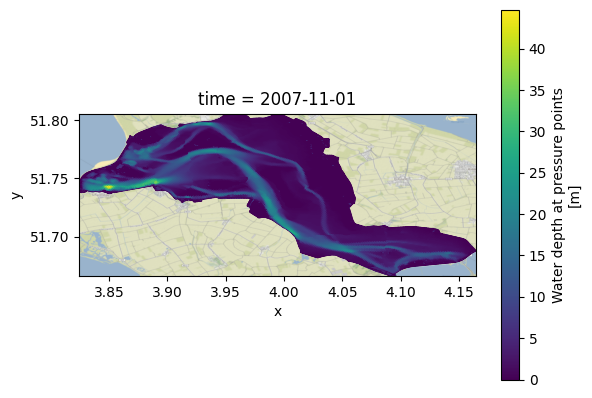

In [9]:
#coordinate conversion
if crs == 'EPSG:28992':
    to_crs = 'EPSG:4326'
elif crs == 'EPSG:4326':
    to_crs = 'EPSG:28992'
if crs is not None:
    uds_map.ugrid.set_crs(crs)
    uds_map_conv = uds_map.ugrid.to_crs(to_crs)
    fig, ax = plt.subplots()
    uds_map_conv["mesh2d_waterdepth"].isel(time=0).ugrid.plot(ax=ax)
    ctx.add_basemap(ax=ax, source=None, crs=to_crs, attribution=False)


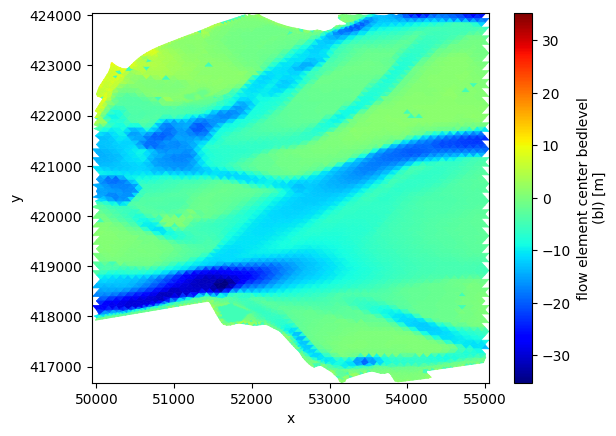

In [10]:
#ugrid sel via x/y
uds_map_sel = uds_map.ugrid.sel(x=sel_slice_x,y=sel_slice_y)
fig, ax = plt.subplots()
pc = uds_map_sel['mesh2d_flowelem_bl'].ugrid.plot(ax=ax, linewidth=0.5, cmap='jet')


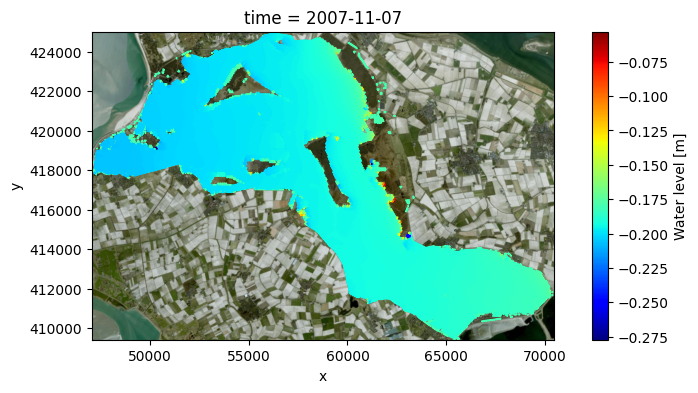

In [11]:
#filter dry cells
bool_drycells = uds_map['mesh2d_s1']==uds_map['mesh2d_flowelem_bl']
uds_map['mesh2d_s1_filt'] = uds_map['mesh2d_s1'].where(~bool_drycells)

#plot water level on map
fig, ax = plt.subplots(figsize=(10,4))
pc = uds_map['mesh2d_s1_filt'].isel(time=3).ugrid.plot(cmap='jet')
if crs is None:
    ax.set_aspect('equal')
else:
    ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)


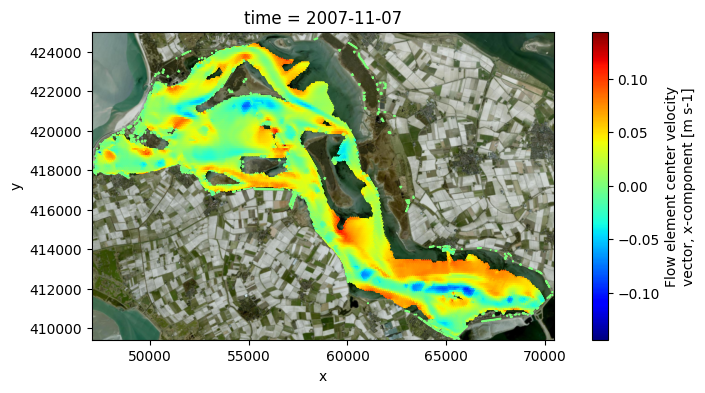

In [12]:
#plot eastward velocities on map, on layer
fig, ax = plt.subplots(figsize=(10,4))
pc = uds_map['mesh2d_ucx'].isel(time=3,mesh2d_nLayers=layer,nmesh2d_layer=layer,missing_dims='ignore').ugrid.plot(cmap='jet')
if crs is None:
    ax.set_aspect('equal')
else:
    ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)


z-layer model, computing zw/zcc (fullgrid) values and treat as fullgrid model from here
>> subsetting data on fixed depth in fullgrid z-data: 0.23 sec


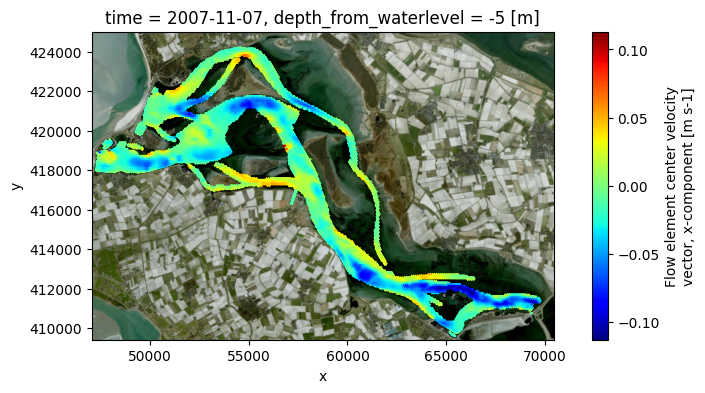

In [13]:
#plot eastward velocities on map, on depth from waterlevel/z0/bedlevel
uds_map_atdepths = dfmt.get_Dataset_atdepths(data_xr=uds_map.isel(time=3), depths=-5, reference='waterlevel')
fig, ax = plt.subplots(figsize=(10,4))
pc = uds_map_atdepths['mesh2d_ucx'].ugrid.plot(cmap='jet')
if crs is None:
    ax.set_aspect('equal')
else:
    ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)


>> rasterizing ugrid Dataset with 2 face variables to shape=(31,47): 0.03 sec


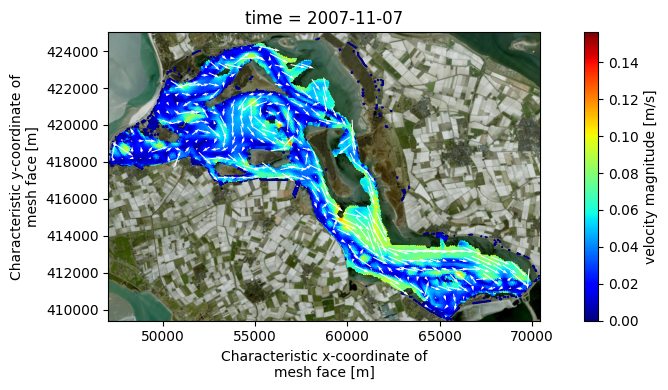

In [14]:
# velocity magnitude and quiver
uds_quiv = uds_map.isel(time=-1, mesh2d_nLayers=-2, nmesh2d_layer=-2, missing_dims='ignore')
varn_ucx, varn_ucy = 'mesh2d_ucx', 'mesh2d_ucy'
magn_attrs = {'long_name':'velocity magnitude', 'units':'m/s'}
uds_quiv['magn'] = np.sqrt(uds_quiv[varn_ucx]**2+uds_quiv[varn_ucy]**2).assign_attrs(magn_attrs)
raster_quiv = dfmt.rasterize_ugrid(uds_quiv[[varn_ucx,varn_ucy]], resolution=raster_res)

#plot
fig,ax = plt.subplots(figsize=(10,4))
pc = uds_quiv['magn'].ugrid.plot(cmap='jet')
raster_quiv.plot.quiver(x='mesh2d_face_x',y='mesh2d_face_y',u=varn_ucx,v=varn_ucy,color='w',scale=scale,add_guide=False)
pc.set_clim(umag_clim)
fig.tight_layout()
if crs is None:
    ax.set_aspect('equal')
else:
    ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)


z-layer model, computing zw/zcc (fullgrid) values and treat as fullgrid model from here


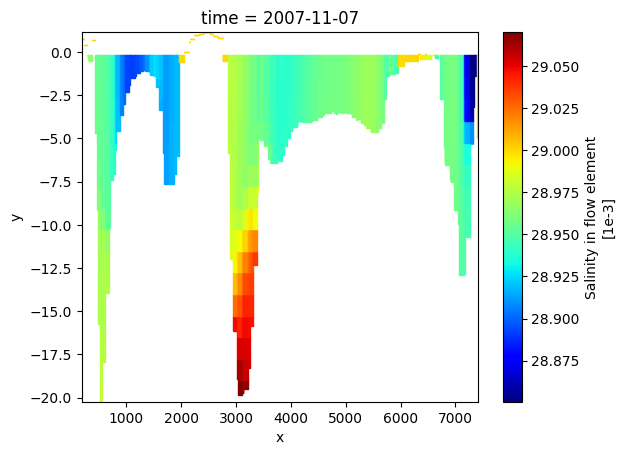

In [15]:
#plot slice/sideview trough 3D salinity mapdata
if line_array is not None:
    uds_crs = dfmt.polyline_mapslice(uds_map.isel(time=3), line_array)
    fig, ax = plt.subplots()
    uds_crs['mesh2d_sa1'].ugrid.plot(cmap='jet')
